Paper link 
https://link.springer.com/article/10.1007/s10660-022-09560-w

In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import NuSVC
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [6]:
# Load datasets
train_df = pd.read_csv("/kaggle/input/sentiment-analysis/test.csv", encoding='latin1')
test_df = pd.read_csv("/kaggle/input/sentiment-analysis/train.csv", encoding='latin1')

In [7]:
# Assuming train_df has 'text' and 'label' columns
X_train = train_df['sentence']
y_train = train_df['label']
X_test = test_df['sentence']
y_test = test_df['label']

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
# Function to clean text
import re
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove special characters and numbers
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', '', text)
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    return text

# Apply the cleaning function to the datasets
X_train_cleaned = X_train.apply(clean_text)
X_test_cleaned = X_test.apply(clean_text)


In [10]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

X_train_cleaned = X_train_cleaned.apply(remove_stopwords)
X_test_cleaned = X_test_cleaned.apply(remove_stopwords)


In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

X_train_tokenized = X_train_cleaned.apply(word_tokenize)
X_test_tokenized = X_test_cleaned.apply(word_tokenize)


In [8]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

X_train_tokenized = X_train_cleaned.apply(word_tokenize)
X_test_tokenized = X_test_cleaned.apply(word_tokenize)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Use top 5000 features

X_train_vectorized = tfidf_vectorizer.fit_transform(X_train_cleaned)
X_test_vectorized = tfidf_vectorizer.transform(X_test_cleaned)

In [12]:
bow_vectorizer = CountVectorizer(max_features=5000)

X_train_vectorized = bow_vectorizer.fit_transform(X_train_cleaned)
X_test_vectorized = bow_vectorizer.transform(X_test_cleaned)


In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_vectorized.toarray())
X_test_normalized = scaler.transform(X_test_vectorized.toarray())

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [17]:
# Initialize the k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the k-NN classifier
knn_classifier.fit(X_train_vectorized, y_train)


KNeighborsClassifier()

In [18]:
# Predict the labels for the test data
y_pred = knn_classifier.predict(X_test_vectorized)


In [22]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 51.19%

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.99      0.67      4000
           1       0.78      0.03      0.06      4000

    accuracy                           0.51      8000
   macro avg       0.65      0.51      0.37      8000
weighted avg       0.65      0.51      0.37      8000


Confusion Matrix:
[[3964   36]
 [3869  131]]


In [12]:
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {"Model": model_name, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1}

In [25]:
from sklearn.metrics import pairwise_distances

def knn_predict(X_train, y_train, X_test, k=5):
    distances = 1 - cosine_similarity(X_test, X_train)  # Cosine similarity converted to distance
    predictions = []
    for dist in distances:
        nearest = np.argsort(dist)[:k]  # Top k nearest neighbors
        nearest_labels = y_train.iloc[nearest]
        predictions.append(nearest_labels.value_counts().idxmax())  # Majority voting
    return predictions

knn_preds = knn_predict(X_train_vectorized, y_train, X_test_vectorized, k=5)
knn_results = evaluate_model(y_test, knn_preds, "k-NN")

In [26]:
knn_results

{'Model': 'k-NN',
 'Accuracy': 0.585625,
 'Precision': 0.586125740437764,
 'Recall': 0.585625,
 'F1-Score': 0.5850218227353117}

In [27]:
nb_model = MultinomialNB(alpha=1)
nb_model.fit(X_train_vectorized, y_train)
nb_preds = nb_model.predict(X_test_vectorized)
nb_results = evaluate_model(y_test, nb_preds, "Naive Bayes")

In [29]:
nb_results

{'Model': 'Naive Bayes',
 'Accuracy': 0.625125,
 'Precision': 0.6251267595950568,
 'Recall': 0.625125,
 'F1-Score': 0.6251236820754448}

In [30]:
svm_model = NuSVC(kernel='rbf', gamma=1e-3, nu=0.5, cache_size=80, shrinking=True)
svm_model.fit(X_train_vectorized, y_train)
svm_preds = svm_model.predict(X_test_vectorized)
svm_results = evaluate_model(y_test, svm_preds, "SVM")

In [31]:
svm_results

{'Model': 'SVM',
 'Accuracy': 0.67625,
 'Precision': 0.6856484529295589,
 'Recall': 0.67625,
 'F1-Score': 0.6721000158252888}

In [55]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(
    n_estimators=600,  # Number of trees in the forest
    max_depth=None,    # Let the trees grow until all leaves are pure
    random_state=42    # For reproducibility
)

# Train the Random Forest model
random_forest_model.fit(X_train_vectorized, y_train)


RandomForestClassifier(n_estimators=600, random_state=42)

In [56]:
# Predict the labels for the test data
rf_preds = random_forest_model.predict(X_test_vectorized)

In [57]:
# Evaluate the Random Forest model
rf_results=evaluate_model(y_test, rf_preds, "Random Forest")

{'Model': 'Random Forest',
 'Accuracy': 0.69825,
 'Precision': 0.6985598029325255,
 'Recall': 0.69825,
 'F1-Score': 0.6981322527118234}

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_23/2106934879.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}, torch.tensor(self.labels[idx])


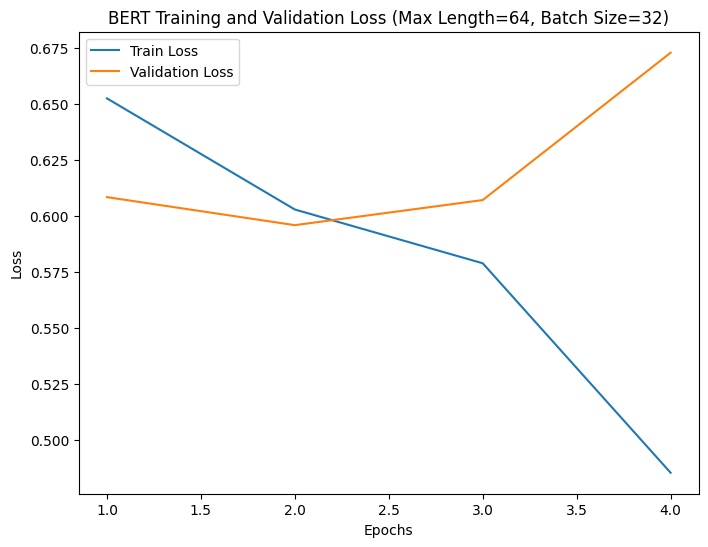

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/tmp/ipykernel_23/2106934879.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}, torch.tensor(self.labels[idx])


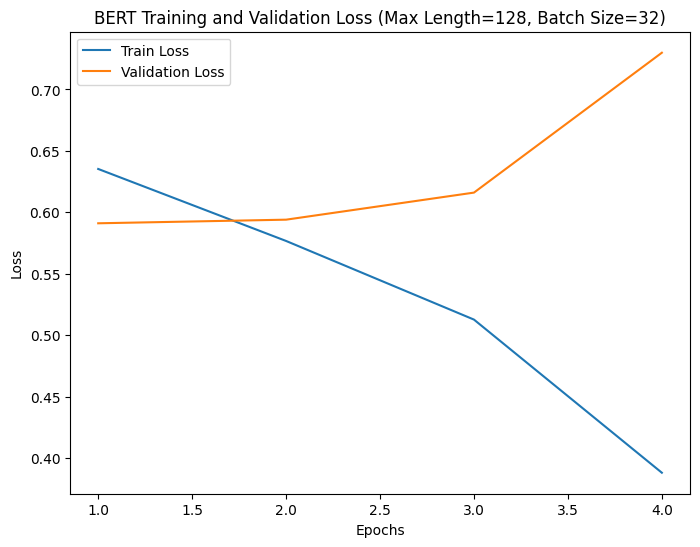

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/tmp/ipykernel_23/2106934879.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}, torch.tensor(self.labels[idx])


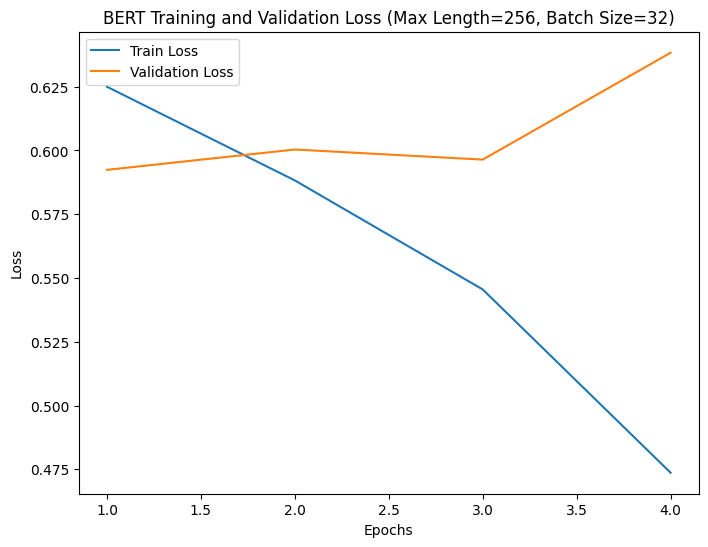

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/tmp/ipykernel_23/2106934879.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}, torch.tensor(self.labels[idx])


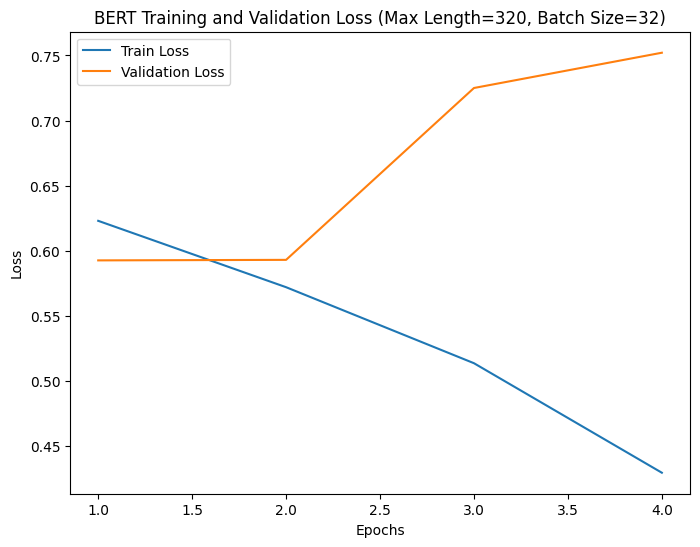

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/tmp/ipykernel_23/2106934879.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}, torch.tensor(self.labels[idx])


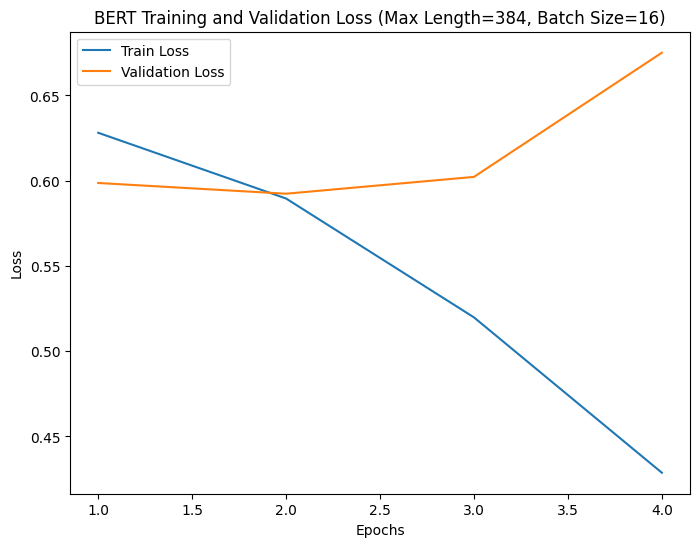

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/tmp/ipykernel_23/2106934879.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}, torch.tensor(self.labels[idx])


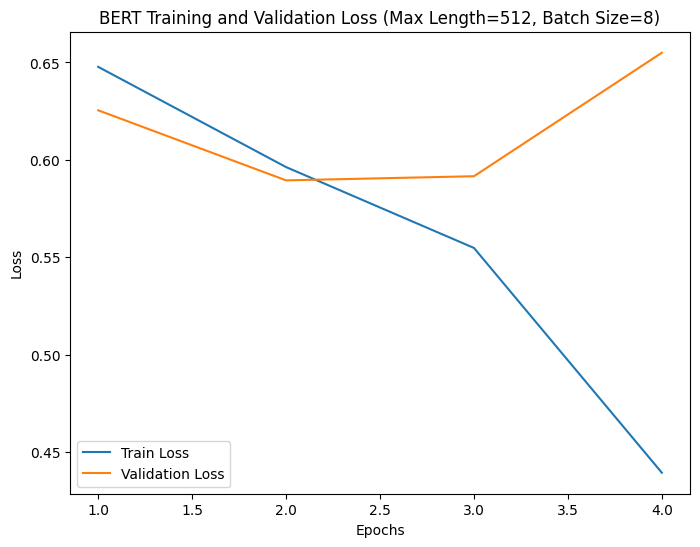

In [13]:
# 4. BERT Fine-Tuning with Multiple Hyperparameters
def bert_fine_tune(train_texts, train_labels, test_texts, test_labels, max_length, batch_size):
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    # Encoding function
    def encode(texts):
        return tokenizer(texts, truncation=True, padding="max_length", max_length=max_length, return_tensors="pt")

    train_encodings = encode(train_texts)
    test_encodings = encode(test_texts)

    class ReviewDataset(Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}, torch.tensor(self.labels[idx])

        def __len__(self):
            return len(self.labels)

    train_dataset = ReviewDataset(train_encodings, train_labels)
    test_dataset = ReviewDataset(test_encodings, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)

    train_losses, val_losses = [], []

    def train_epoch():
        model.train()
        total_loss = 0
        for batch, labels in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(**batch, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(train_loader)

    def eval_epoch():
        model.eval()
        total_loss = 0
        predictions, true_labels = [], []
        with torch.no_grad():
            for batch, labels in test_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                labels = labels.to(device)
                outputs = model(**batch, labels=labels)
                loss = outputs.loss
                preds = torch.argmax(outputs.logits, dim=1)
                total_loss += loss.item()
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        return total_loss / len(test_loader), predictions, true_labels

    for epoch in range(4):
        train_loss = train_epoch()
        val_loss, _, _ = eval_epoch()
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    _, preds, true = eval_epoch()
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 5), train_losses, label="Train Loss")
    plt.plot(range(1, 5), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"BERT Training and Validation Loss (Max Length={max_length}, Batch Size={batch_size})")
    plt.legend()
    plt.show()

    return evaluate_model(true, preds, f"BERT_{max_length}_{batch_size}")

# Compare BERT for different hyperparameters
bert_results = []
bert_configs = [
    (64, 32),
    (128, 32),
    (256, 32),
    (320, 32),
    (384, 16),
    (512, 8)
]

for max_length, batch_size in bert_configs:
    result = bert_fine_tune(X_train_cleaned.tolist(), train_df['label'].tolist(),
                            X_test_cleaned.tolist(), test_df['label'].tolist(),
                            max_length=max_length, batch_size=batch_size)
    bert_results.append(result)

In [14]:
results_df = pd.DataFrame(bert_results)
print("\nComparison of Models:")
print(results_df)


Comparison of Models:
         Model  Accuracy  Precision    Recall  F1-Score
0   BERT_64_32  0.634125   0.652216  0.634125  0.622921
1  BERT_128_32  0.685000   0.685078  0.685000  0.684967
2  BERT_256_32  0.688750   0.694198  0.688750  0.686551
3  BERT_320_32  0.655625   0.685136  0.655625  0.641332
4  BERT_384_16  0.683500   0.683544  0.683500  0.683481
5   BERT_512_8  0.683125   0.683445  0.683125  0.682987


Apply openai embadding

from openai import OpenAI
import pandas as pd
from dotenv import load_dotenv

load_dotenv()


In [ ]:
def generate_embeddings(text):
    client = OpenAI()
    response = client.embeddings.create(input=text, model="text-embedding-3-small")
    del client
    return response.data[0].embedding

In [ ]:
test_df = pd.read_csv("train.csv", encoding='latin1')

In [ ]:
test_df['embedding'] = test_df['sentence'].apply(generate_embeddings)